## 1. 모델링

사전설정 (모델 훈련과 예측 모두 공통)

In [1]:
import os

model_save_path = "saved_model1"
# cols = ["KOSPI", "KOSPI_VOL", "CR", "GOLD", "NASDAQ", "DOW", "NIKKEI", "SHANGHAI", "INDI", "FOREIGN", "ORG"]
# cols = ["KOSPI", "KOSPI_VOL", "CR", "GOLD", "NASDAQ", "DOW", "NIKKEI", "SHANGHAI"]
cols = ["KOSPI", "KOSPI_START", "KOSPI_HIGH", "KOSPI_LOW", "NASDAQ", "DOW", "CR", "GOLD"]
len_x_ARMA = 60
len_y_nextday = 20
scale_method = "norm"

# 패키지 캐시 모두 지우기 (tf 등 이전에 남은 가비지가 영향을 미칠 수 있음)
for dir_ in ["/Users/hrdkdh/Documents/GitHub/predict/", "/Users/hrdkdh/venv/"]:
    os.system("find {} | grep -E '(__pycache__|\.pyc$|\pyo$)' | xargs rm -rf".format(dir_))

1-1) 데이터 크롤링

In [2]:
from kospi_predict import Crawler

crawler = Crawler(crawl_page_max=30, perPage=100)
crawler.crawlData(cols, save=True)
# crawler.loadFromSavedFile(cols)
df_crawled = crawler.removeNan()
df_crawled = df_crawled.loc[:2000]
df_crawled


KOSPI : 데이터 수집중...
KOSPI_START : 데이터 수집중...
KOSPI_HIGH : 데이터 수집중...
KOSPI_LOW : 데이터 수집중...
NASDAQ : 30번째 페이지 데이터 수집중...
DOW : 30번째 페이지 데이터 수집중...
CR : 30번째 페이지 데이터 수집중...


,date,KOSPI,KOSPI_START,KOSPI_HIGH,KOSPI_LOW,NASDAQ,DOW,CR,GOLD
0,2022-04-05,2759.20,2765.50,2769.18,2750.50,14532.5540,34921.88,1214.0,1930.62
1,2022-04-04,2757.90,2729.86,2758.38,2722.45,14261.5000,34818.27,1216.0,1931.35
2,2022-04-01,2739.85,2745.85,2745.85,2729.68,14220.5190,34678.35,1218.0,1932.32
3,2022-03-31,2757.65,2743.24,2765.20,2743.20,14442.2750,35228.81,1213.5,1926.45
4,2022-03-30,2746.74,2758.31,2760.60,2740.02,14619.6360,35294.19,1211.5,1920.92
...,...,...,...,...,...,...,...,...,...
1996,2014-02-20,1930.57,1932.90,1941.13,1927.53,4237.9540,16040.56,1074.0,1314.80
1997,2014-02-19,1942.93,1944.70,1944.70,1932.44,4272.7830,16130.40,1065.5,1321.10
1998,2014-02-18,1946.91,1946.88,1951.06,1935.60,4244.0250,16154.39,1065.5,1320.08
1999,2014-02-17,1946.36,1951.74,1955.04,1942.94,4242.3485,16090.99,1060.5,1325.30


1-2. 데이터 전처리

In [3]:
from kospi_predict import DataPreprocessor

dpp = DataPreprocessor(df_crawled, cols, scale_method, model_save_path)
dpp.sortByDate()
dpp.makeDiffRatio()
dpp.scalingForModeling()
dpp.makeAR(0, len_x_ARMA)
# dpp.makeMA(2, len_x_ARMA)
dpp.makeTargetYs(len_y_nextday)
dpp.cutoffData(len_x_ARMA, len_y_nextday)

자기상관 생성중... (100.00%)



In [4]:
dpp.getRemoveColByRegression(threshold=0.7)
# dpp.remove_cols

In [5]:
#상관계수로 드랍할 변수 선택하기
# dpp.getRemoveColByCorr(threshold=0.7)
# len(dpp.remove_cols)

In [6]:
#변수 선택하고 데이터 분할
dpp.df.drop(columns=dpp.remove_cols, inplace=True)
dpp.splitData()
# dpp.df.to_excel("processed_data.xlsx", index=False)
dpp.df

,date,KOSPI,KOSPI_START,KOSPI_HIGH,KOSPI_LOW,NASDAQ,DOW,CR,GOLD,X_KOSPI_AR0,...,Y_KOSPI_nextday_11,Y_KOSPI_nextday_12,Y_KOSPI_nextday_13,Y_KOSPI_nextday_14,Y_KOSPI_nextday_15,Y_KOSPI_nextday_16,Y_KOSPI_nextday_17,Y_KOSPI_nextday_18,Y_KOSPI_nextday_19,Y_KOSPI_nextday_20
0,2014-05-15,-0.702389,-0.710860,-0.713579,-0.685114,-1.106325,-1.201428,-2.199234,-0.429925,-0.702389,...,-0.742407,-0.723921,-0.706695,-0.741041,-0.755326,-0.698188,-0.690652,-0.698582,-0.753199,-0.746004
1,2014-05-16,-0.693882,-0.722403,-0.718606,-0.709203,-1.115659,-1.229521,-2.222954,-0.469150,-0.693882,...,-0.723921,-0.706695,-0.741041,-0.755326,-0.698188,-0.690652,-0.698582,-0.753199,-0.746004,-0.725102
2,2014-05-19,-0.689418,-0.695355,-0.713162,-0.694342,-1.109316,-1.222042,-2.272371,-0.444051,-0.689418,...,-0.706695,-0.741041,-0.755326,-0.698188,-0.690652,-0.698582,-0.753199,-0.746004,-0.725102,-0.756770
3,2014-05-20,-0.699606,-0.700445,-0.715949,-0.690561,-1.098822,-1.218589,-2.209117,-0.477710,-0.699606,...,-0.741041,-0.755326,-0.698188,-0.690652,-0.698582,-0.753199,-0.746004,-0.725102,-0.756770,-0.750100
4,2014-05-21,-0.707299,-0.722403,-0.712902,-0.697383,-1.107438,-1.241705,-2.189350,-0.467009,-0.707299,...,-0.755326,-0.698188,-0.690652,-0.698582,-0.753199,-0.746004,-0.725102,-0.756770,-0.750100,-0.813015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,2022-02-28,1.106743,1.007807,1.067544,1.038630,1.751515,1.730353,1.329167,1.893077,1.106743,...,1.094480,1.127329,1.072266,1.135154,1.200931,1.186778,1.187618,1.186515,1.216738,1.231627
1916,2022-03-02,1.118139,1.100440,1.112554,1.128510,1.703210,1.601988,1.388468,2.045188,1.118139,...,1.127329,1.072266,1.135154,1.200931,1.186778,1.187618,1.186515,1.216738,1.231627,1.260274
1917,2022-03-03,1.232519,1.183210,1.195253,1.218708,1.768611,1.702220,1.378584,2.016821,1.232519,...,1.072266,1.135154,1.200931,1.186778,1.187618,1.186515,1.216738,1.231627,1.260274,1.213535
1918,2022-03-04,1.144161,1.200839,1.164960,1.155218,1.704843,1.685970,1.586137,2.041764,1.144161,...,1.135154,1.200931,1.186778,1.187618,1.186515,1.216738,1.231627,1.260274,1.213535,1.260931


1-3) 모델 훈련하고 생성

2022-04-06 11:35:23.731739: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-06 11:35:23.731866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-06 11:35:23.825747: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 548)               0         
                                                                 
 dense (Dense)               (None, 1024)              562176    
                                                                 
 dense_1 (Dense)             (None, 20)                20500     
                                                                 
 dense_2 (Dense)             (None, 1024)              21504     
                                                                 
 dense_3 (Dense)             (None, 20)                20500     
                                                                 
Total params: 624,680
Trainable params: 624,680
Non-trainable params: 0
_______________________________________

2022-04-06 11:35:23.998416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-06 11:35:25.231165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


모델 생성 완료1500/1500(100%) loss : 0.0010, mae : 0.0237, mse : 0.0010 / val_loss : 0.0038, val_mae : 0.0436, val_mse : 0.0038                              


2022-04-06 11:56:37.837345: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: kospi_predictor_model/saved_model1/assets
모델 저장 완료
check point : cp-1042


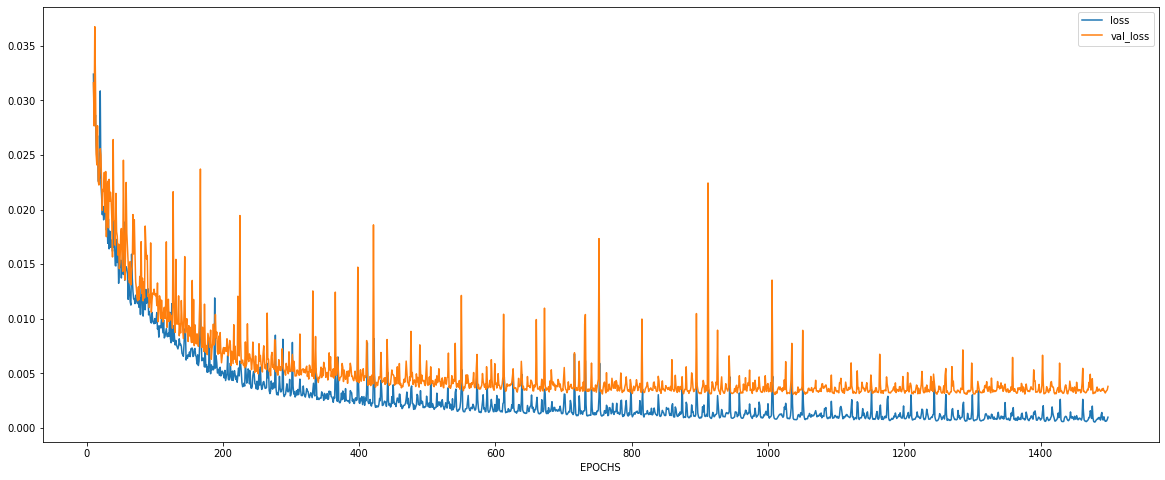

In [7]:
from kospi_predict import ModelMaker

maker = ModelMaker(
    dpp.y_list,
    dpp.df_train,
    dpp.df_test,
    perceptron_vol = 1024,
    dense_vol1 = 1,
    dense_vol2 = 1,
    activation_method = "relu",
    optimizer_str = "Adam",
    model_save_path = model_save_path)
maker.makeModel(EPOCHS=1500, batch_size=8, learning_rate=0.0001, save_by_checkpoint=True)

INFO:tensorflow:Assets written to: kospi_predictor_model/saved_model1/assets
모델 저장 완료
check point : cp-0535


2022-04-06 11:56:39.063207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


,y_no,test_mae,test_mse
0,0,0.045379,0.003810
1,1,0.044434,0.003460
2,2,0.040167,0.002859
3,3,0.042958,0.003490
4,4,0.042542,0.003122
5,5,0.041131,0.003478
6,6,0.044171,0.003700
7,7,0.043169,0.003563
8,8,0.042867,0.003173
9,9,0.043522,0.003739


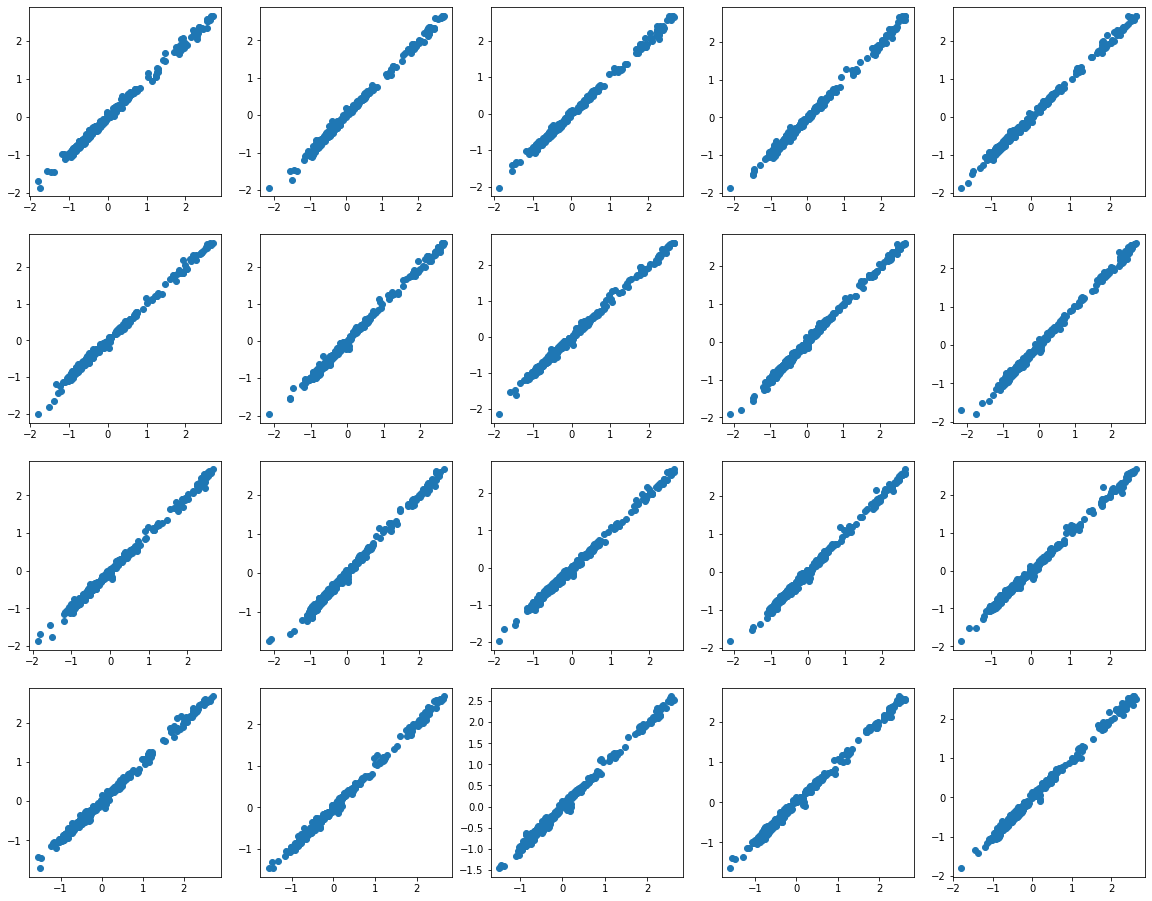

In [8]:
maker.saveModelByCheckpoint(-10)
maker.validateModel()
maker.test_error

## 2. 최근 데이터로 20일 간의 KOSPI 지수 예측

2-1) 데이터 수집

In [9]:
from kospi_predict import Crawler

#예측을 위해서는 현재기준 이전 10일간의 데이터만 있으면 됨 (len_x_ARMA가 10일때)
crawler_pred = Crawler(crawl_page_max=1, perPage=100) #이전 추세도 볼겸 넉넉히 수집
crawler_pred.crawlData(cols)
df_crawled_pred = crawler_pred.removeNan()
df_crawled_pred


KOSPI : 데이터 수집중...
KOSPI_START : 데이터 수집중...
KOSPI_HIGH : 데이터 수집중...
KOSPI_LOW : 데이터 수집중...
NASDAQ : 1번째 페이지 데이터 수집중...
DOW : 1번째 페이지 데이터 수집중...
CR : 1번째 페이지 데이터 수집중...


,date,KOSPI,KOSPI_START,KOSPI_HIGH,KOSPI_LOW,NASDAQ,DOW,CR,GOLD
0,2022-04-05,2759.20,2765.50,2769.18,2750.50,14532.554,34921.88,1214.0,1930.62
1,2022-04-04,2757.90,2729.86,2758.38,2722.45,14261.500,34818.27,1216.0,1931.35
2,2022-04-01,2739.85,2745.85,2745.85,2729.68,14220.519,34678.35,1218.0,1932.32
3,2022-03-31,2757.65,2743.24,2765.20,2743.20,14442.275,35228.81,1213.5,1926.45
4,2022-03-30,2746.74,2758.31,2760.60,2740.02,14619.636,35294.19,1211.5,1920.92
...,...,...,...,...,...,...,...,...,...
87,2021-11-25,2980.27,2996.74,2996.74,2973.24,15810.182,35809.09,1190.5,1794.49
88,2021-11-24,2994.29,3006.34,3017.90,2981.02,15775.138,35813.80,1187.5,1791.45
89,2021-11-23,2997.33,3013.16,3016.36,2992.14,15854.757,35619.25,1189.0,1801.10
90,2021-11-22,3013.25,2983.38,3018.01,2980.73,16057.438,35601.98,1187.0,1844.75


2-2) 데이터 전처리

In [10]:
from kospi_predict import DataPreprocessor

#아래는 예측을 위한 전처리
dpp_pred = DataPreprocessor(df_crawled_pred.loc[:100], cols, scale_method, model_save_path)
dpp_pred.sortByDate()
dpp_pred.makeDiffRatio()
dpp_pred.scalingForPredict()
dpp_pred.makeAR(0, len_x_ARMA)
# dpp_pred.makeMA(2, len_x_ARMA)
dpp_pred.cutoffData(len_x_ARMA, 0)

자기상관 생성중... (100.00%)



2-3) 예측

2022-04-06 11:56:44.563100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


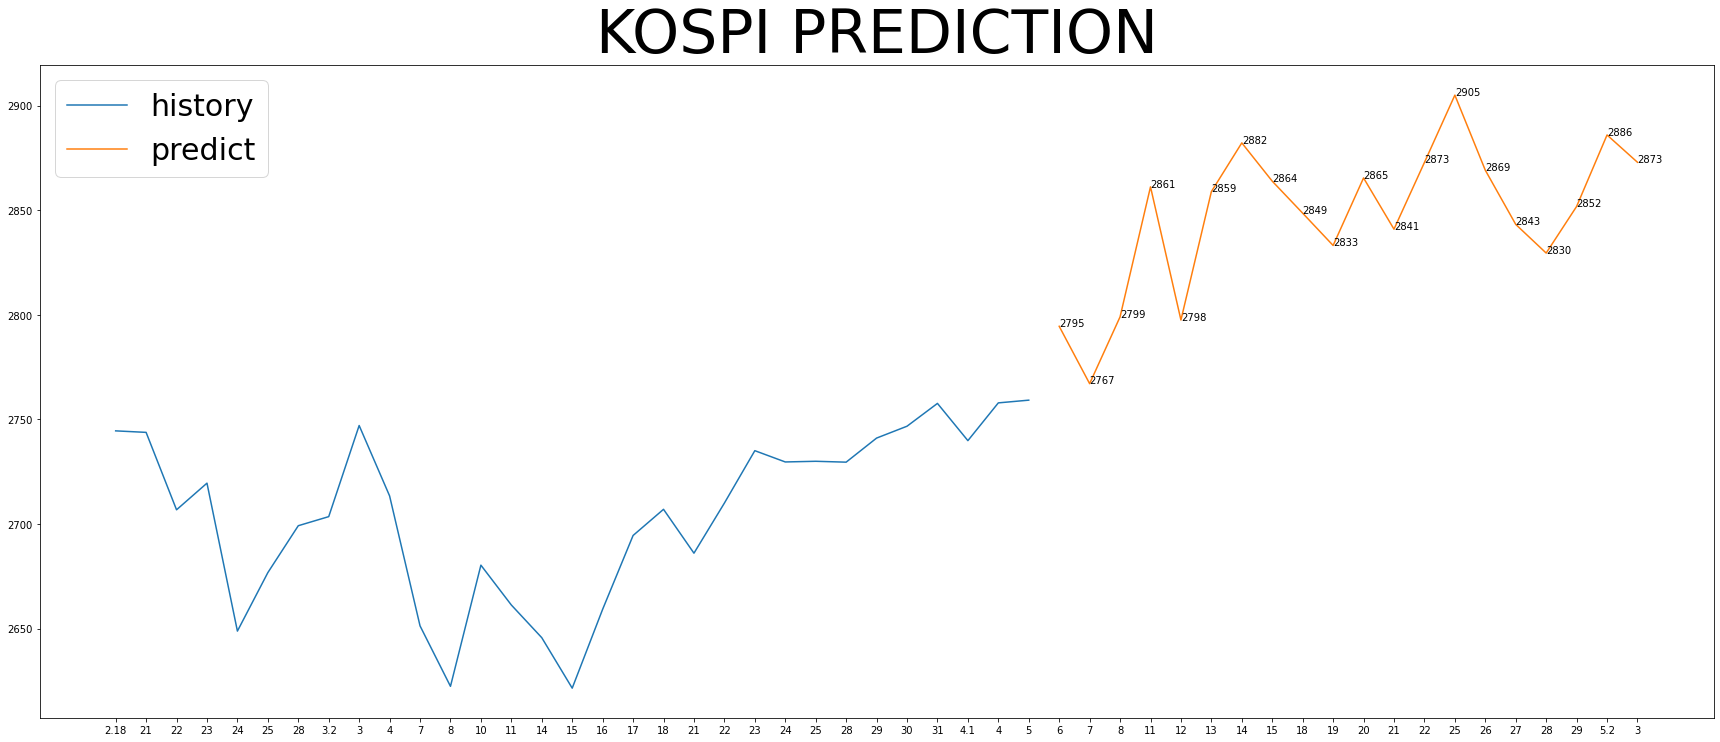

In [11]:
from kospi_predict import Predictor

#2.18 기준으로 20일 뒤까지 예측하고 시각화

predictor = Predictor(dpp_pred.df, scale_method = scale_method, model_save_path=model_save_path)
predictor.predict()
predictor.showPredictionPlot()

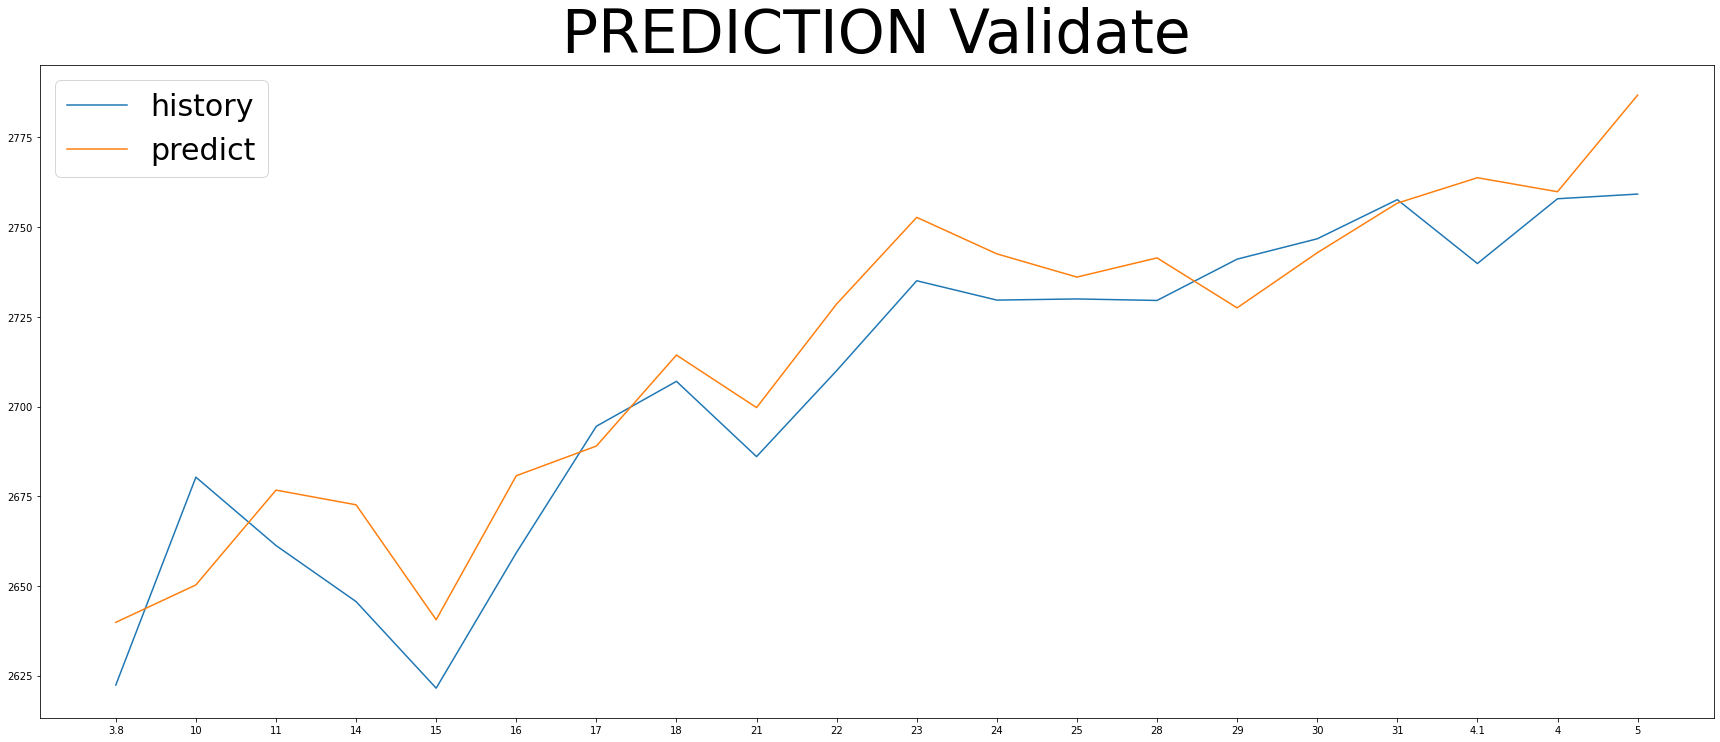

In [12]:
#실제 기록과 예측값을 비교하여 예측이 얼마나 잘 맞는지 확인한다
history_before = 21
df_result = predictor.predict(history_before)
predictor.showPredictionByHistory(df_result, history_before)

In [13]:
len(predictor.x_cols)
predictor.saveModelToJS()